The data I am using for this project is from kaggle. The dataset contains the conversion rates of two groups (control and treatment) exposed to different landing pages. The dataset comprises twenty-nine thousand rows of datapoints

# Import modules

In [96]:
import pandas as pd
import numpy as np
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportion_effectsize
import statsmodels.stats as sms
import statsmodels as sm
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load and Examine Data

In [47]:
# load in the data
result = pd.read_csv('dataset/ab_data.csv')


# Print the columns of customer data
print(f'There are {result.shape[0]} rows and {result.shape[1]} columns in the `result`')


There are 294478 rows and 5 columns in the `result`


In [172]:
result.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [171]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [48]:
result['timestamp'] = pd.to_datetime(result['timestamp'])#.dt.tz_localize(None)
result['date'] = result['timestamp'].dt.floor('d')
result.head()

,user_id,timestamp,group,landing_page,converted,date
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21


# Data cleaning & Sanity check

In [49]:
# It does not make sense that the control group get exposed to the new page and the test group to old page. 
result = result[((result.group == 'control') & (result.landing_page == 'old_page')) | ((result.group == 'treatment') & (result.landing_page == 'new_page'))]

# Helper functions

In [204]:
# Define helper functions

# Define a function that set the plotting style
def plot_style_setting(figsize=[10, 6]):
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['axes.labelpad'] = 10
    plt.rcParams['axes.grid.axis'] = 'y'
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['font.family'] = "monospace"
    params = {i:'#595959' for i in ["axes.titlecolor", "ytick.color", "xtick.color","axes.labelcolor","text.color"]}
    plt.rcParams.update(params)

# Define a fucntion that derives p-values
def get_pvalue(p1, p2, p1_size, p2_size):  
    lift =  - abs(p2 - p1)

    scale_one = p1 * (1 - p1) * (1 / p1_size)
    scale_two = p2 * (1 - p1) * (1 / p2_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * scipy.stats.norm.cdf(lift, loc = 0, scale = scale_val )

    return p_value

# Define a fucntion that derives confidence interval
def get_ci(value, cl, sd):
    rng_val = scipy.stats.norm.ppf(1 - confidence_level / 2) * sd
    # loc = scipy.stats.norm.ppf(1 - cl/2)
    # rng_val = scipy.stats.norm.cdf(loc - value/sd)
    
    lwr_bnd = value - rng_val
    upr_bnd = value + rng_val 
    
    return_val = (lwr_bnd, upr_bnd)
    
    return(return_val)

# Define a fucntion that derives statistical power
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    
    qu = scipy.stats.norm.ppf(1 - alpha/2)
    
    diff = abs(p2 - p1)
    bp = (p1 + p2) / 2
    
    v1 = p1 * (1 - p1)
    v2 = p2 * (1 - p2)
    
    bv = bp * (1 - bp)
    
    power_part_one = scipy.stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    power_part_two = 1 - scipy.stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    
    power = power_part_one + power_part_two

    return(power)


# Calculate the metrics

In [191]:
# Find the unique users in each group 
results = result.groupby('group').agg({'user_id': pd.Series.nunique}) 

# Find the overall number of unique users using "len" and "unique"
unique_users = len(result.user_id.unique()) 

# Find the percentage in each group
results = results / unique_users
print(results)

            user_id
group              
control    0.499938
treatment  0.500062


No handles with labels found to put in legend.


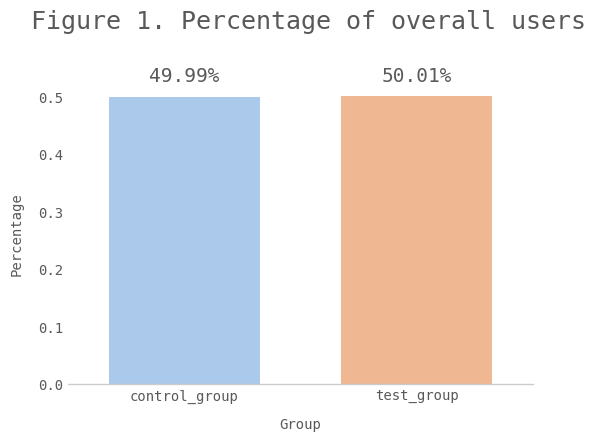

In [196]:
f1_df = results.reset_index().rename({'user_id': 'percentage'}, axis=1)
plot_style_setting(figsize=[6, 4])
g = sns.barplot(f1_df['group'], f1_df['percentage'], palette='pastel')

for idx, bar in enumerate(g.patches):
    bar.set_width(0.65)
    bar.set_x(g.get_xticks()[idx] - (0.65 * .5))
    g.annotate(f'{f1_df["percentage"][idx]:.2%}',  
               (bar.get_x() + bar.get_width() / 2,  
                bar.get_height()), ha='center', va='center', 
                xytext=(0, 15), textcoords='offset points', fontsize=14) 

g.set_xticklabels([i for i in ['control_group', 'test_group']])

plt.title(f'Figure 1. Percentage of overall users', 
          fontsize=18, 
          loc='left',
          x=-0.08,
          y=1.15)

plt.xlabel("Group")
plt.ylabel("Percentage")
plt.legend().remove()
plt.grid(False)
sns.despine(left=True)
plt.savefig('Figure1', facecolor='white', bbox_inches="tight", dpi=100)

In [137]:
# Find the unique users in each group, by landing page
results = result.groupby(by=['group', 'landing_page']).agg({'user_id': pd.Series.nunique}) 

# Find the number of unique users by group
control_size = results.loc[('control', 'old_page'), 'user_id'] 
test_size = results.loc[('treatment', 'new_page'), 'user_id'] 

# Find the coverted number of unique users by group
result_converted = result.groupby(['group', 'landing_page'])['converted'].sum()

# Find the percentage in each group
con_conv_num = result_converted.loc[('control', 'old_page')]
test_conv_num = result_converted.loc[('treatment', 'new_page')]
con_conv = con_conv_num / control_size
test_conv =  test_conv_num / test_size


No handles with labels found to put in legend.


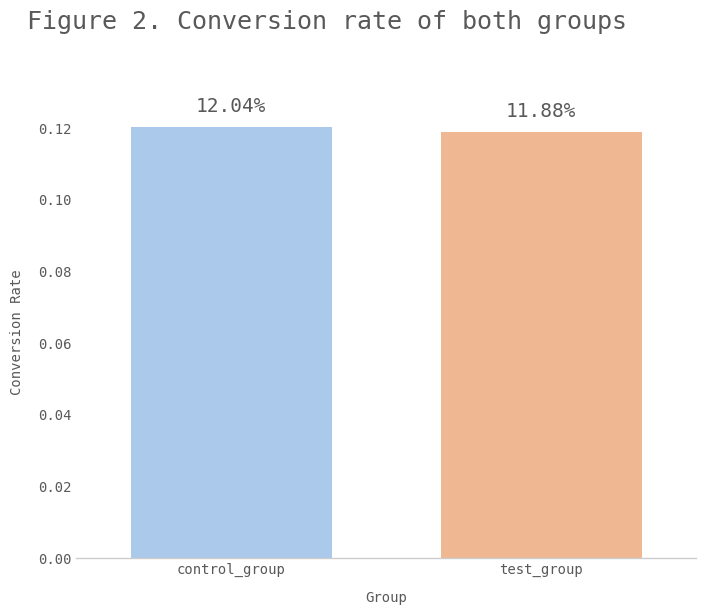

In [197]:
f2_df = pd.DataFrame([['control_group', con_conv], ['test_group', test_conv]], columns=['group', 'conversion_rate'])
plot_style_setting(figsize=[8, 6])
g2 = sns.barplot(f2_df['group'], f2_df['conversion_rate'], palette='pastel')

for idx, bar in enumerate(g2.patches):
    bar.set_width(0.65)
    bar.set_x(g2.get_xticks()[idx] - (0.65 * .5))
    g2.annotate(f'{bar_df["conversion_rate"][idx]:.2%}',  
               (bar.get_x() + bar.get_width() / 2,  
                bar.get_height()), ha='center', va='center', 
                xytext=(0, 15), textcoords='offset points', fontsize=14) 


plt.title(f'Figure 2. Conversion rate of both groups', 
          fontsize=18, 
          loc='left',
          x=-0.08,
          y=1.15)

plt.xlabel("Group")
plt.ylabel("Conversion Rate")
plt.legend().remove()
plt.grid(False)
sns.despine(left=True)
plt.savefig('Figure2', facecolor='white', bbox_inches="tight", dpi=100)

In [278]:
# Get the p-value
get_pvalue(con_conv, test_conv, control_size, test_size)

0.18968514748095755

In [307]:
# Find the power
get_power(test_size, con_conv, test_conv, 0.95)

0.2587176865444471

In [163]:
# Calculate the mean of our lift distribution 
lift_mean = test_conv - con_conv

# Calculate variance and standard deviation 
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - con_conv) * con_conv / control_size
lift_sd = lift_variance**0.5

# Find the confidence intervals with cl = 0.95
confidence_interval = get_ci(lift_mean, 0.05, lift_sd)
print(confidence_interval)

(-0.003937860245052736, 0.0007813822743416229)


No handles with labels found to put in legend.


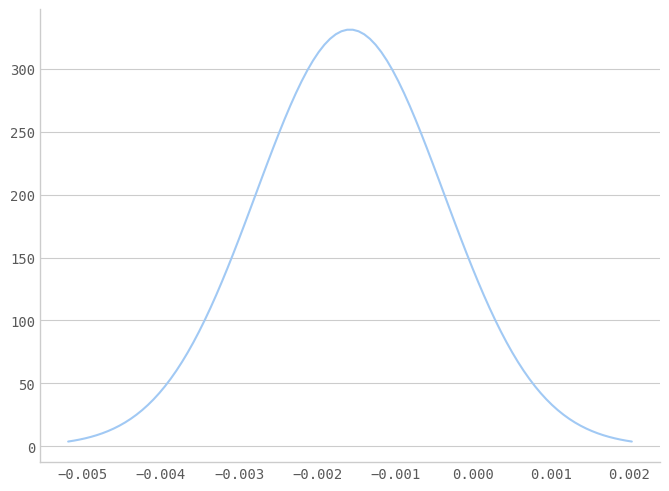

In [198]:
# Plot the diiference in conversion rate a distribution

# Generate a range of values across the distribution fro, +/- 2 sd around the mean
diff = np.linspace(-3*lift_sd+lift_mean, 3*lift_sd+lift_mean, 100)
y = scipy.stats.norm.pdf(diff, lift_mean, lift_sd)
plt.plot(diff, y, color='#a1c9f4')

plt.legend().remove()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('Figure3', facecolor='white', bbox_inches="tight", dpi=100)


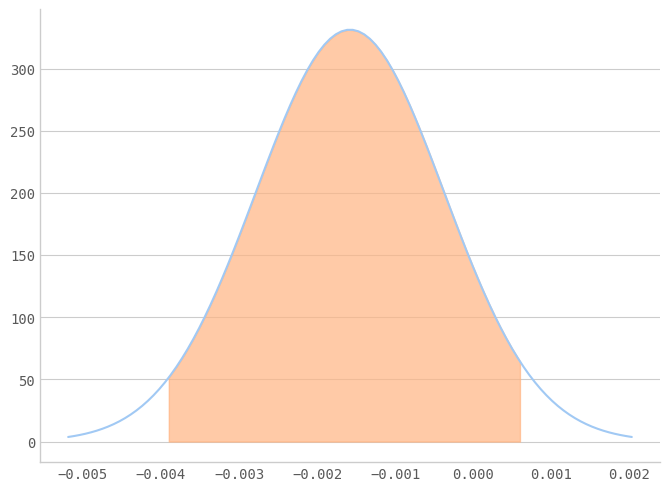

In [199]:
# Plot the confidence interval

interval = np.arange(-0.0039, 0.0007, 1/10000)
plt.fill_between(interval, scipy.stats.norm.pdf(interval, lift_mean, lift_sd), color='#ffb482', alpha=0.7)
plt.plot(diff, y, color='#a1c9f4')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('Figure4', facecolor='white', bbox_inches="tight", dpi=100)

In [208]:
# Check what sample size is required
practical_significance = 0.005 
confidence_level = 0.05 
power = 0.8 
effect_size = proportion_effectsize(con_conv, con_conv + practical_significance)
sample_size = TTestIndPower().solve_power(effect_size = effect_size, power = power, 
                                               alpha = confidence_level)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  67674  per group
